<h2> Module: ANLY 510 - Analytics II: Principal & Applications </h2>
<h2> Instructor: Dr. Ziyuan Huang </h2>
<h2> Student: Noopur Singh </h2>
<h2> Assignment: Logistic Regression </h2>

<h3> Problem Statement: </h3>
<h4>Breast cancer is one of the leading causes of cancer-related deaths among women worldwide. Early and accurate diagnosis is crucial for effective treatment and better patient outcomes.<br/>

The goal of this project is to build a robust and interpretable logistic regression model to predict whether a tumor is malignant or benign using the Wisconsin Diagnostic Breast Cancer (WDBC) dataset. The analysis involves:<br/>
	‚Ä¢	Performing exploratory data analysis (EDA)<br/>
	‚Ä¢	Preprocessing and standardizing features<br/>
	‚Ä¢	Using multiple random seeds to evaluate model stability<br/>
	‚Ä¢	Comparing different solvers and regularization strengths<br/>
	‚Ä¢	Interpreting model outputs via coefficients and odds ratios<br/>
	‚Ä¢	Evaluating performance using accuracy, ROC AUC, and confusion matrices<br/>

This solution aims to provide a lightweight, reliable, and explainable model suitable for medical diagnostics, where transparency and consistency are essential.</h4>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve,ConfusionMatrixDisplay)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')


In [2]:

# ---------------------------------------------
# Generate 5 random seeds from student ID
# ---------------------------------------------
student_id = "325562"  
seed_base = sum([ord(c) for c in student_id])
np.random.seed(seed_base)
seeds = np.random.randint(1, 10000, size=5)
print("Random Seeds:", seeds)

# ---------------------------------------------
# Load dataset using ucimlrepo
# ---------------------------------------------
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets['Diagnosis'].map({'M': 1, 'B': 0})  # Encode target


Random Seeds: [2753 5214 9191 1578 4462]


The code is generating five seeds using which we split the data multiple times to test the model's stability across different train/test splits.

The datset is loaded using fetch_ucirepo library from ucimlrepo. <br/>
It includes 30 features with target variable as "Diagnosis" with values "M" (malignant) and "B" (benign).

We have encoded the target variable: "M"->1, "B"->0.

In [3]:

# ---------------------------------------------
# EDA
# ---------------------------------------------
print("\nSummary Statistics:")
print(X.describe().T)

print("\nMissing values in features:\n", X.isnull().sum())
print("Missing values in target:\n", y.isnull().sum())


Summary Statistics:
                    count        mean         std         min         25%  \
radius1             569.0   14.127292    3.524049    6.981000   11.700000   
texture1            569.0   19.289649    4.301036    9.710000   16.170000   
perimeter1          569.0   91.969033   24.298981   43.790000   75.170000   
area1               569.0  654.889104  351.914129  143.500000  420.300000   
smoothness1         569.0    0.096360    0.014064    0.052630    0.086370   
compactness1        569.0    0.104341    0.052813    0.019380    0.064920   
concavity1          569.0    0.088799    0.079720    0.000000    0.029560   
concave_points1     569.0    0.048919    0.038803    0.000000    0.020310   
symmetry1           569.0    0.181162    0.027414    0.106000    0.161900   
fractal_dimension1  569.0    0.062798    0.007060    0.049960    0.057700   
radius2             569.0    0.405172    0.277313    0.111500    0.232400   
texture2            569.0    1.216853    0.551648    0.

The data has 569 rows and None of the features have any missing value.
The statistics show that some features like area and radius have high variation.

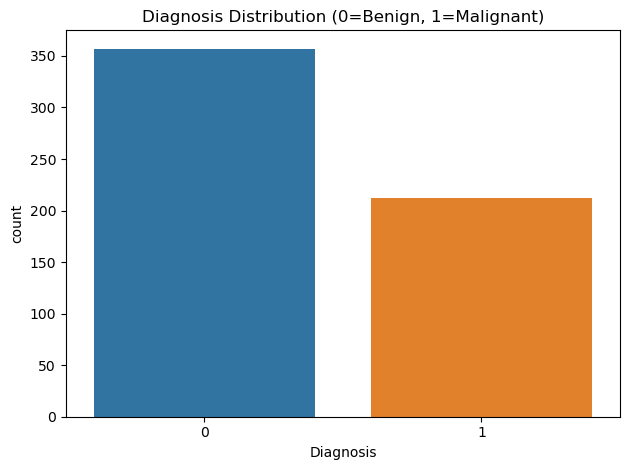

In [4]:
sns.countplot(x=y)
plt.title("Diagnosis Distribution (0=Benign, 1=Malignant)")
plt.xlabel("Diagnosis")
plt.tight_layout()
plt.show()


There are more benign cases than malignant. </br>

Typical numbers from the WDBC dataset:</br>
	‚Ä¢	Benign: ~357 samples</br>
	‚Ä¢	Malignant: ~212 samples</br>
</br>
This is a mild class imbalance ‚Äî not severe, but still important to be aware of when evaluating precision/recall.
</br>
Since benign cases outnumber malignant, using only accuracy may hide poor performance on malignant predictions. That‚Äôs why we also use:</br>
	‚Ä¢	Recall (sensitivity to detect malignancy)</br>
	‚Ä¢	Precision (avoiding false positives)</br>

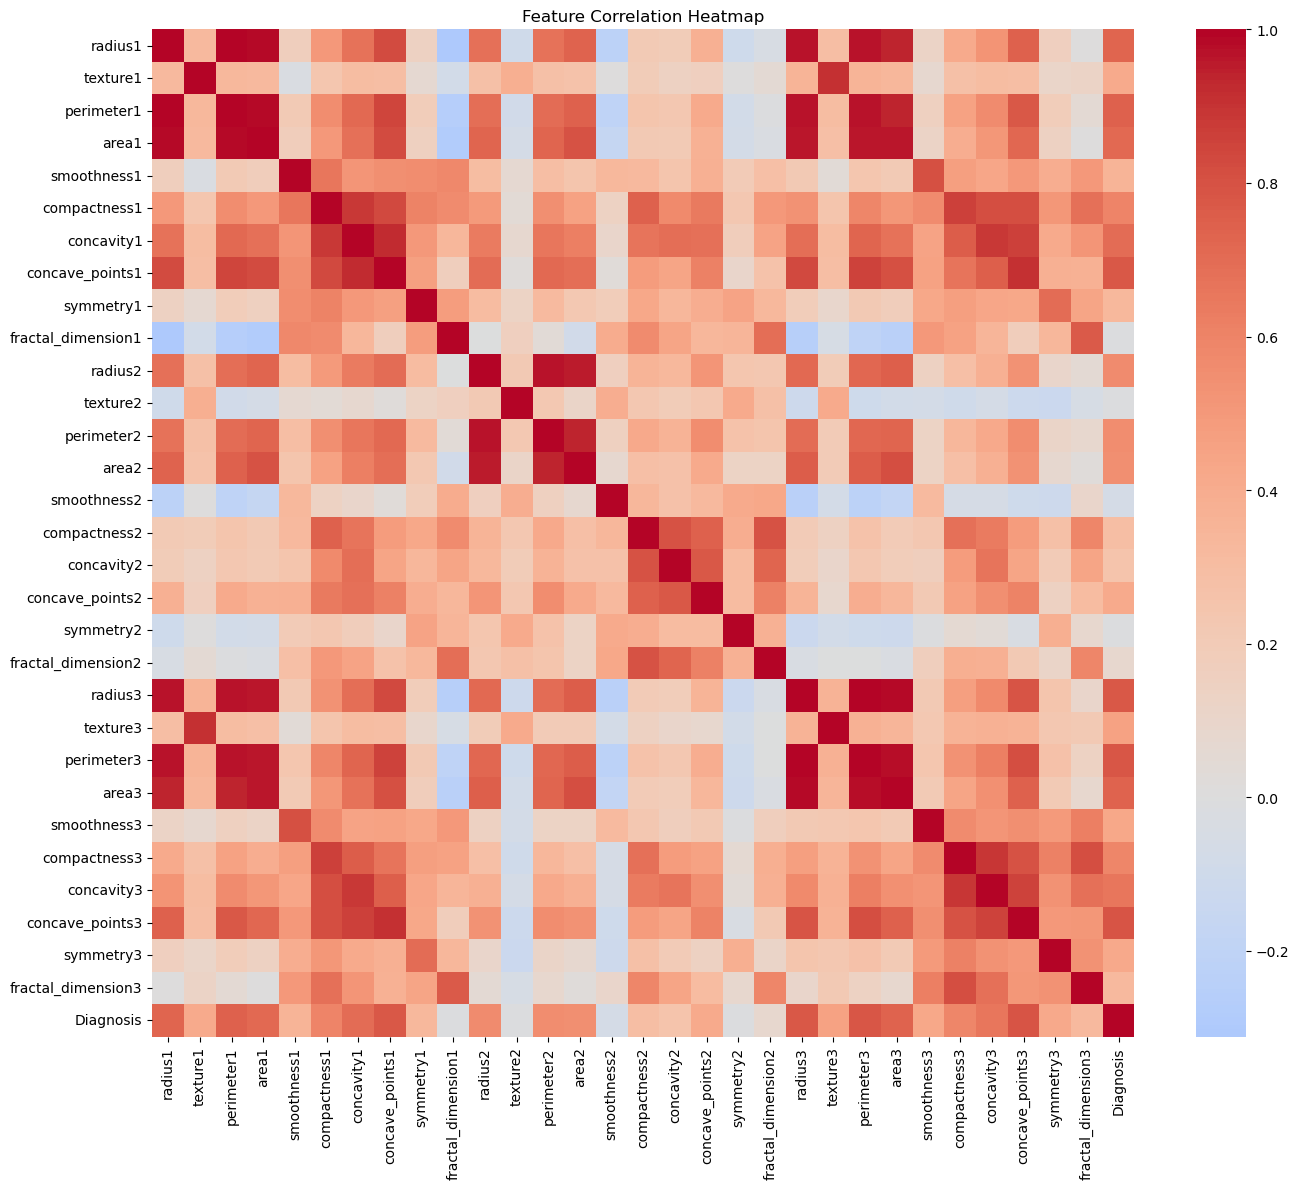

In [5]:
df = X.copy()
df['Diagnosis'] = y
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

Plotting the heatmap to check the correlation between each pair of features. 
</br>
It visually represents how strongly each pair of features is correlated.</br>
	‚Ä¢	Dark red = High positive correlation (close to +1)</br>
	‚Ä¢	Light blue = Negative correlation (closer to ‚Äì1)</br>
	‚Ä¢	White/beige = No correlation (~0)</br>
    
We notice several blocks of dark red along the diagonal ‚Äì these indicate strong positive correlations. For example:</br>
	‚Ä¢	radius1, perimeter1, and area1 are highly correlated.</br>
	‚Ä¢	Similarly, their counterparts radius2, perimeter2, area2 and radius3, perimeter3, area3 are also highly correlated.</br>

These features likely capture similar shape-related properties of the tumor (size-related).


üîÅ Seed 2753 - Logistic Regression with Scaling
Accuracy: 0.9561
ROC-AUC Score: 0.9732
Confusion Matrix:
 [[70  2]
 [ 3 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97        72
           1       0.95      0.93      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



<Figure size 600x500 with 0 Axes>

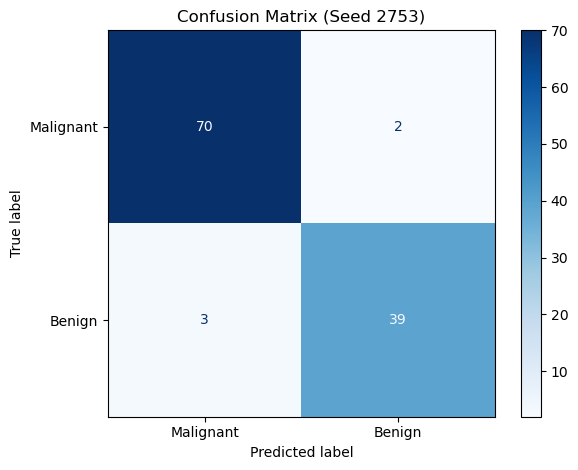


üîÅ Seed 5214 - Logistic Regression with Scaling
Accuracy: 0.9737
ROC-AUC Score: 0.9977
Confusion Matrix:
 [[70  2]
 [ 1 41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



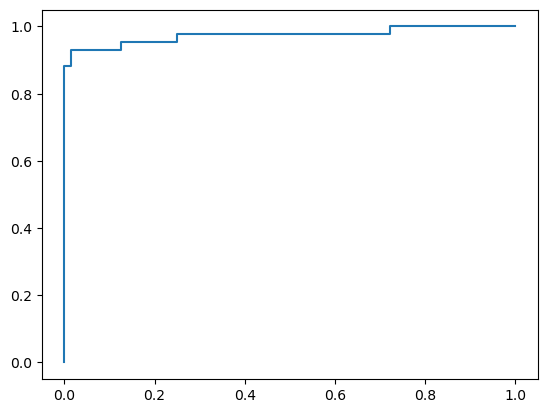

<Figure size 600x500 with 0 Axes>

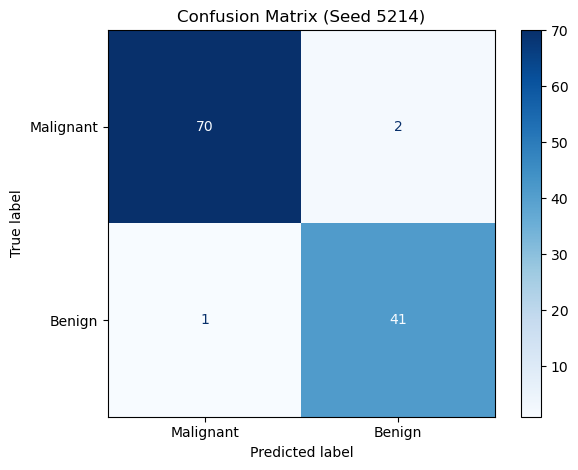


üîÅ Seed 9191 - Logistic Regression with Scaling
Accuracy: 0.9912
ROC-AUC Score: 0.9993
Confusion Matrix:
 [[72  0]
 [ 1 41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        72
           1       1.00      0.98      0.99        42

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



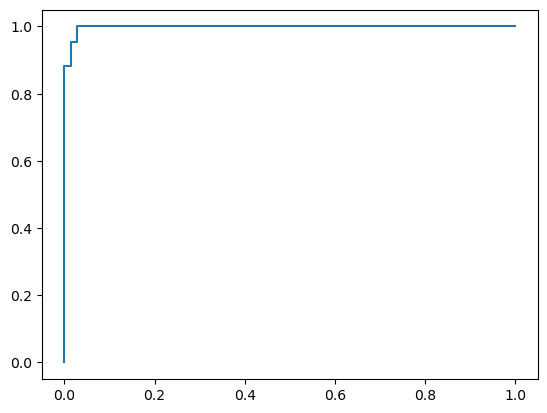

<Figure size 600x500 with 0 Axes>

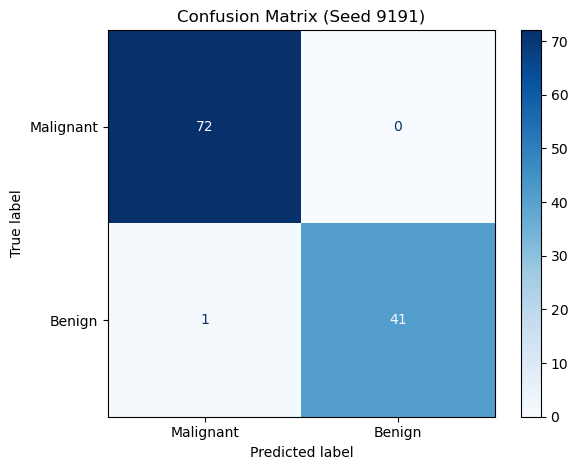


üîÅ Seed 1578 - Logistic Regression with Scaling
Accuracy: 0.9737
ROC-AUC Score: 0.9864
Confusion Matrix:
 [[72  0]
 [ 3 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



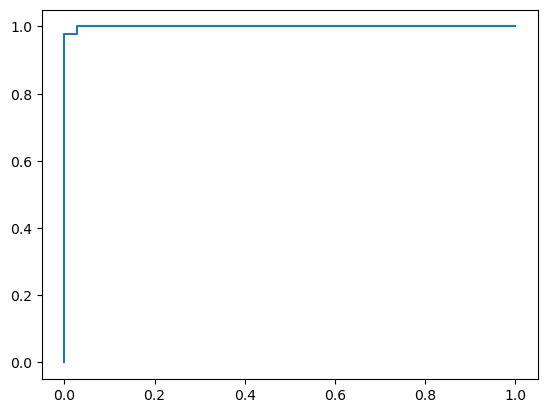

<Figure size 600x500 with 0 Axes>

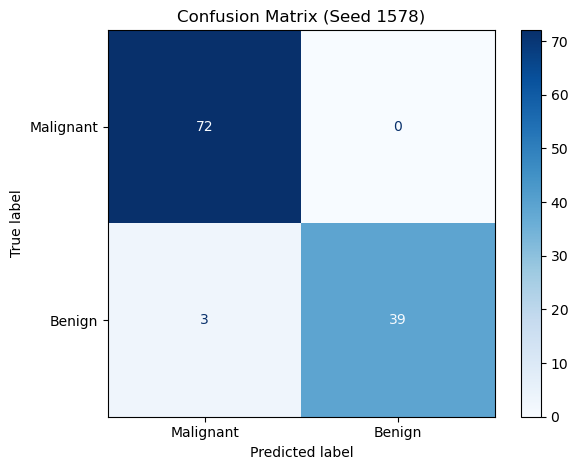


üîÅ Seed 4462 - Logistic Regression with Scaling
Accuracy: 0.9737
ROC-AUC Score: 0.9970
Confusion Matrix:
 [[70  2]
 [ 1 41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



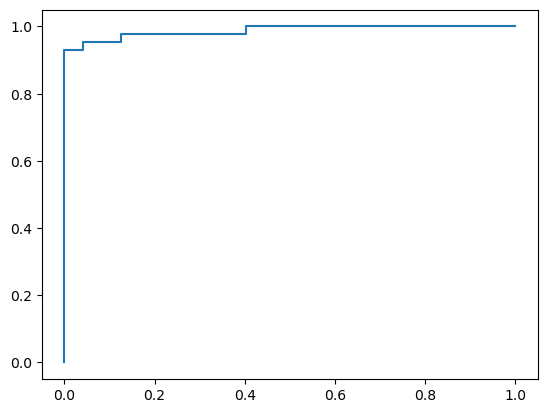

<Figure size 600x500 with 0 Axes>

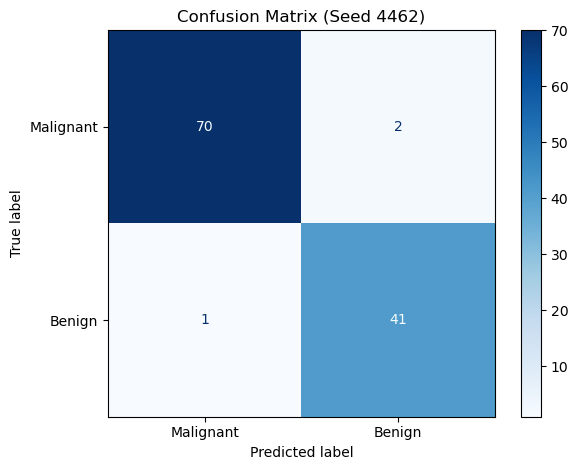

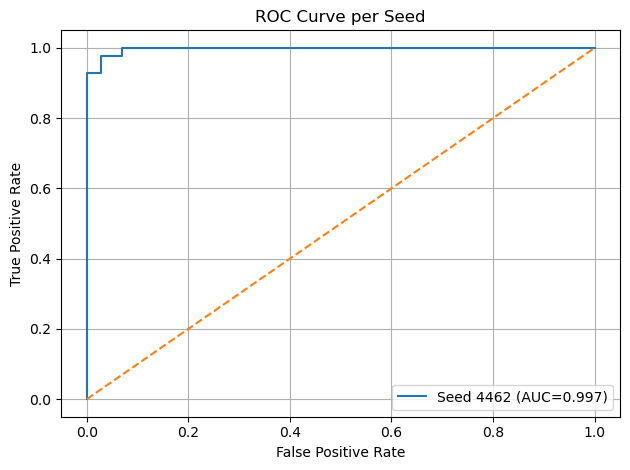

In [6]:
# ---------------------------------------------
# Model Evaluation using 5 seeds
# ---------------------------------------------
for seed in seeds:
    print("\n" + "="*70)
    print(f"üîÅ Seed {seed} - Logistic Regression with Scaling")
    print("="*70)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed
    )

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=1000, random_state=seed))
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Malignant", "Benign"])
    
    # Plot
    plt.figure(figsize=(6, 5))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix (Seed {seed})")
    plt.tight_layout()
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"Seed {seed} (AUC={roc_auc_score(y_test, y_proba):.3f})")

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Seed")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

    


I have now split the data into train and test dataset for each seed.</br>
Using the train test data, I ran logistic regression with a pipeline (scaling + model) for each seed. </br>
For each seed, I print accuracy, ROC AUC, classification report, and confusion matrix.</br>

The output is as such:</br>

As we can see, the Accuracy for each model ranges between 95-99% and ROC AUC is greater than 0.97.</br>
The ROC AUC values near 1.0 show excellent separation between classes.</br>
</br>
The plot of ROC AUC curves for all models are overlapping, all bending toward the top-left corner.</br>
</br>
Conclusion:</br>
The model is stable across seeds, with high true positive rates and low false positives. ROC AUC > 0.97 is very strong.</br>

In [7]:
# ---------------------------------------------
# Solver Comparison
# ---------------------------------------------
print("\n" + "=" * 60)
print("üîç Solver Comparison (CV=5)")
print("=" * 60)

solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
solver_results = {}
for solver in solvers:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=1000, solver=solver, random_state=seeds[0]))
    ])
    scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
    solver_results[solver] = {
        'mean_accuracy': scores.mean(),
        'std_accuracy': scores.std(),
        'scores': scores
    }
    print(f"Solver: {solver} | Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")



üîç Solver Comparison (CV=5)
Solver: lbfgs | Accuracy: 0.9807 (+/- 0.0131)
Solver: liblinear | Accuracy: 0.9789 (+/- 0.0140)
Solver: newton-cg | Accuracy: 0.9807 (+/- 0.0131)
Solver: sag | Accuracy: 0.9807 (+/- 0.0131)
Solver: saga | Accuracy: 0.9807 (+/- 0.0131)


The above code compares the solvers like 'lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'.

I ran 5-fold cross-validation using cross_val_score for each solver.</br>

Each solver's average accuracy across 5 folds is 97-98%. </br>

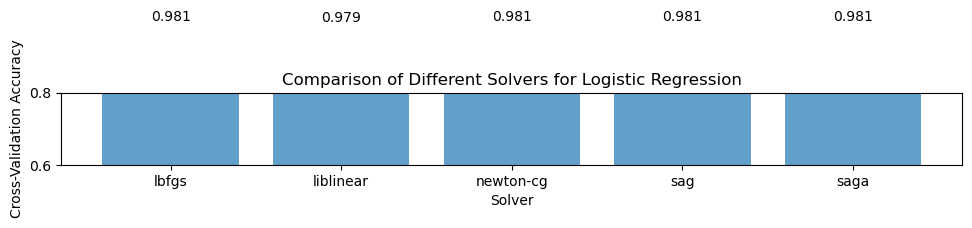

In [8]:
# --- Visualization 3: Solver Comparison ---
plt.figure(figsize=(10, 6))
solvers_list = list(solver_results.keys())
means = [solver_results[s]['mean_accuracy'] for s in solvers_list]
stds = [solver_results[s]['std_accuracy'] for s in solvers_list]

bars = plt.bar(solvers_list, means, yerr=stds, capsize=10, alpha=0.7)
plt.xlabel('Solver')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Comparison of Different Solvers for Logistic Regression')
plt.ylim(0.6, 0.8)
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{means[i]:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

Above is the plot to show the comparison across solvers.


Top 10 Important Features:
             Feature  Coefficient  Odds Ratio  Abs Coefficient
21         texture3     1.424074    4.154010         1.424074
10          radius2     1.250738    3.492921         1.250738
7   concave_points1     1.024606    2.785998         1.024606
6        concavity1     0.997255    2.710830         0.997255
27  concave_points3     0.969680    2.637101         0.969680
28        symmetry3     0.950454    2.586884         0.950454
13            area2     0.943184    2.568146         0.943184
26       concavity3     0.923766    2.518758         0.923766
23            area3     0.874430    2.397508         0.874430
20          radius3     0.848948    2.337186         0.848948


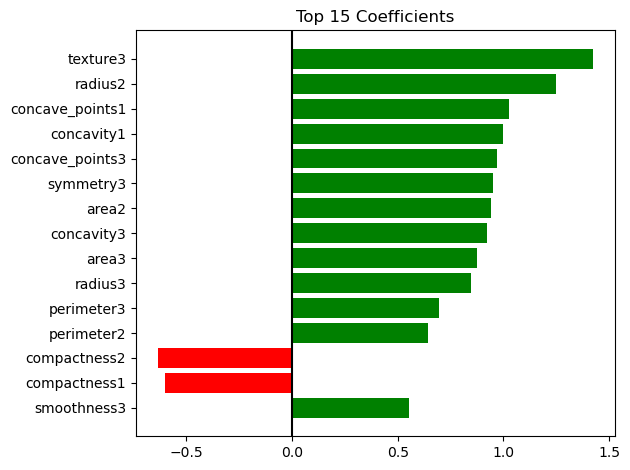

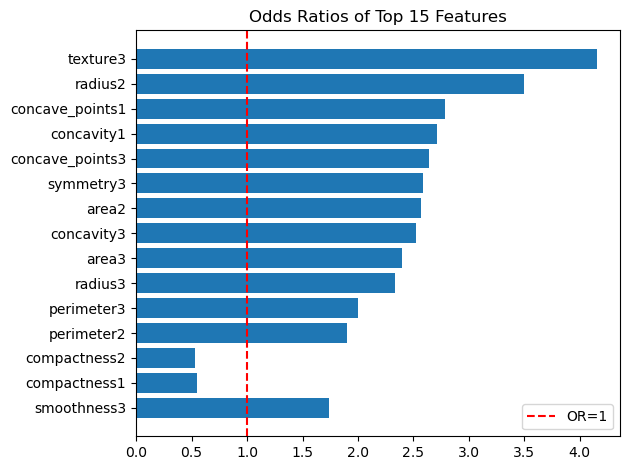

In [9]:

# ---------------------------------------------
# Feature Importance
# ---------------------------------------------
model = pipeline.named_steps["logreg"]
coefficients = model.coef_[0]
odds_ratios = np.exp(coefficients)
features = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": coefficients,
    "Odds Ratio": odds_ratios,
    "Abs Coefficient": np.abs(coefficients)
}).sort_values("Abs Coefficient", ascending=False)

print("\nTop 10 Important Features:\n", features.head(10))

# --- Visualization 4: Feature Coefficients ---
top = features.head(15)
colors = ['green' if c > 0 else 'red' for c in top["Coefficient"]]
plt.barh(top["Feature"], top["Coefficient"], color=colors)
plt.title("Top 15 Coefficients")
plt.axvline(x=0, color='black')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

# --- Visualization 5: Odds Ratios ---
plt.barh(top["Feature"], top["Odds Ratio"])
plt.axvline(x=1, color='red', linestyle='--', label='OR=1')
plt.title("Odds Ratios of Top 15 Features")
plt.legend()
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


To understand which features have the biggest influence on whether a tumor is malignant or benign, I am carrying out feature importance.

The above code extracts the coefficients of all the features and calculates the odds ratios.</br>

The coefficient analysis helps justify the model's decisions expecially in sensitive fields like healthcare.

The positive value suggests that feature increases the odds of cancer.

The negative value suggests that feature decreases the odds.

The plot shows the that texture3, radius and concave_points1 has the highest odds ratios.


üìâ Regularization Strength Impact
C=0.001: Accuracy=0.8963 (+/- 0.0525)
C=0.01: Accuracy=0.9526 (+/- 0.0465)
C=0.1: Accuracy=0.9737 (+/- 0.0248)
C=1: Accuracy=0.9789 (+/- 0.0306)
C=10: Accuracy=0.9754 (+/- 0.0281)
C=100: Accuracy=0.9631 (+/- 0.0339)


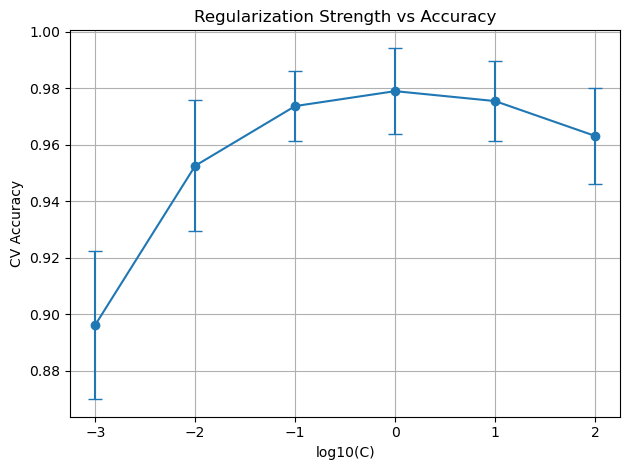

In [10]:

# ---------------------------------------------
# Regularization Strength Analysis
# ---------------------------------------------
print("\n" + "=" * 60)
print("üìâ Regularization Strength Impact")
print("=" * 60)

C_values = [0.001, 0.01, 0.1, 1, 10, 100]
means, stds = [], []
for C in C_values:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=1000, C=C, random_state=seeds[0]))
    ])
    scores = cross_val_score(pipe, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seeds[0]), scoring='accuracy')
    means.append(scores.mean())
    stds.append(scores.std())
    print(f"C={C}: Accuracy={scores.mean():.4f} (+/- {scores.std()*2:.4f})")

# --- Visualization 6: Regularization Strength Impact ---
plt.errorbar(np.log10(C_values), means, yerr=stds, capsize=5, marker='o')
plt.xlabel("log10(C)")
plt.ylabel("CV Accuracy")
plt.title("Regularization Strength vs Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

To find the optimal balance between bias and variance so that the model doesn't overfit or underfit, I carried out regularization strength analysis.

I tune the C parameter in logistic regression in range [0.001,0.01,0.1,1,10,100].

Lower value of C may suggest underfit model and large may suggest overfit.

C with value 0.1 and 1 give good accuracy. Hence, the ideal trade-off point between simplicity and performance.

In [11]:
# --- Final Model Summary ---
print("\n" + "=" * 60)
print("FINAL MODEL SUMMARY")
print("=" * 60)
print(f"Best Accuracy achieved: {max(means):.4f}")
print(f"Optimal C value: {C_values[means.index(max(means))]}")
print(f"Number of features: {X.shape[1]}")
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Class distribution in training set:")
print(f"  - Not Good (0): {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  - Good (1): {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")



FINAL MODEL SUMMARY
Best Accuracy achieved: 0.9789
Optimal C value: 1
Number of features: 30
Training set size: 455
Test set size: 114
Class distribution in training set:
  - Not Good (0): 285 (62.6%)
  - Good (1): 170 (37.4%)
